## This notebook demonstrates some basic data pro-precessing tasks based on Titanic dataset

##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

In [0]:
%fs ls /mnt/isa460/data/titanic

path,name,size
dbfs:/mnt/isa460/data/titanic/titanic-training-data.csv,titanic-training-data.csv,61194


In [0]:
from pyspark.sql.functions import col, isnull, mean, stddev, abs, lit, desc
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.ml.feature import Imputer

## load the Titanic dataset

In [0]:
df =spark.read.csv('/mnt/isa460/titanic/titanic-training-data.csv', header=True, inferSchema=True)

display(df.limit(5))

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,null,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,null,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,null,S


In [0]:
df.printSchema()

root
-- PassengerId: integer (nullable = true)
-- Survived: integer (nullable = true)
-- Pclass: integer (nullable = true)
-- Name: string (nullable = true)
-- Sex: string (nullable = true)
-- Age: double (nullable = true)
-- SibSp: integer (nullable = true)
-- Parch: integer (nullable = true)
-- Ticket: string (nullable = true)
-- Fare: double (nullable = true)
-- Cabin: string (nullable = true)
-- Embarked: string (nullable = true)

### Checking target variable, make sure it includes valid values

In [0]:
display(df.groupBy('Survived').count())

Survived,count
1,342
0,549


### Checking for missing values

In [0]:
display(df.summary())

summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,891,891,714,891,891,891,891,204,889
mean,446.0,0.3838383838383838,2.308641975308642,null,null,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,null,null
stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,null,null,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,null,null
min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
25%,223,0,2,null,null,20.0,0,0,19996.0,7.8958,null,null
50%,446,0,3,null,null,28.0,0,0,236171.0,14.4542,null,null
75%,669,1,3,null,null,38.0,1,0,347743.0,31.0,null,null
max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


In [0]:
 df.schema.fields

Out[16]: [StructField(PassengerId,IntegerType,true),
 StructField(Survived,IntegerType,true),
 StructField(Pclass,IntegerType,true),
 StructField(Name,StringType,true),
 StructField(Sex,StringType,true),
 StructField(Age,DoubleType,true),
 StructField(SibSp,IntegerType,true),
 StructField(Parch,IntegerType,true),
 StructField(Ticket,StringType,true),
 StructField(Fare,DoubleType,true),
 StructField(Cabin,StringType,true),
 StructField(Embarked,StringType,true)]

In [0]:
# retun all numeric columns

result=[]
for x in df.schema.fields:
  if x.dataType!=StringType():
    result.append(x.name)
result

Out[6]: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [0]:
doubleColumns=[x.name for x in df.schema.fields if x.dataType!=StringType()]

display(df.select(doubleColumns).describe())

summary,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891,891,891,714,891,891,891
mean,446.0,0.3838383838383838,2.308641975308642,29.69911764705882,0.5230078563411896,0.38159371492704824,32.2042079685746
stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,14.526497332334035,1.1027434322934315,0.8060572211299488,49.69342859718089
min,1,0,1,0.42,0,0,0.0
max,891,1,3,80.0,8,6,512.3292


In [0]:
# display missing value of each column
cols=df.columns
dict={}

for col in cols:
  missing_value=df.filter(isnull(col)).count()
  dict[col]=missing_value
dict 


Out[18]: {'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [0]:
# make a function for later use
def missingValueCount(df):
  cols=df.columns
  dict={}
  for col in cols:
    missing_value=df.filter(isnull(col)).count()
    dict[col]=missing_value
  return dict

df_result=missingValueCount(df)
df_result

Out[19]: {'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [0]:
result=[({col: df.filter(isnull(col)).count()}) for col in df.columns]
result

Out[20]: [{'PassengerId': 0},
 {'Survived': 0},
 {'Pclass': 0},
 {'Name': 0},
 {'Sex': 0},
 {'Age': 177},
 {'SibSp': 0},
 {'Parch': 0},
 {'Ticket': 0},
 {'Fare': 0},
 {'Cabin': 687},
 {'Embarked': 2}]

### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [0]:
df1 = df.drop('Name', 'Ticket', 'Cabin')
df1.show(5, False)

+-----------+--------+------+------+----+-----+-----+-------+--------+
PassengerId|Survived|Pclass|Sex |Age |SibSp|Parch|Fare |Embarked|
+-----------+--------+------+------+----+-----+-----+-------+--------+
1 |0 |3 |male |22.0|1 |0 |7.25 |S |
2 |1 |1 |female|38.0|1 |0 |71.2833|C |
3 |1 |3 |female|26.0|0 |0 |7.925 |S |
4 |1 |1 |female|35.0|1 |0 |53.1 |S |
5 |0 |3 |male |35.0|0 |0 |8.05 |S |
+-----------+--------+------+------+----+-----+-----+-------+--------+
only showing top 5 rows

### Identify outliers

In [0]:
display(df1)

PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22.0,1,0,7.25,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.925,S
4,1,1,female,35.0,1,0,53.1,S
5,0,3,male,35.0,0,0,8.05,S
6,0,3,male,null,0,0,8.4583,Q
7,0,1,male,54.0,0,0,51.8625,S
8,0,3,male,2.0,3,1,21.075,S
9,1,3,female,27.0,0,2,11.1333,S
10,1,2,female,14.0,1,0,30.0708,C


Databricks visualization. Run in Databricks to view.

Out[18]:

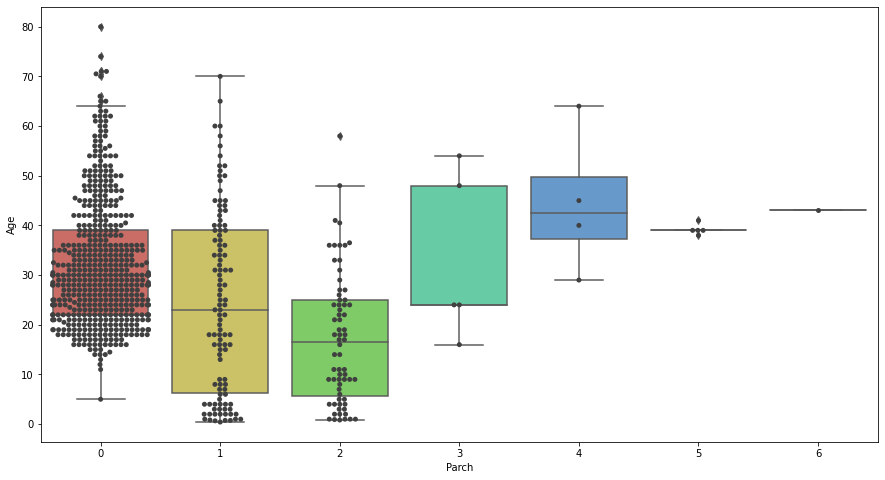

<AxesSubplot:xlabel='Parch', ylabel='Age'>

In [0]:
# set the size of seaborn plot
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pylab import rcParams

rcParams['figure.figsize'] = 15,8

pd=df1.toPandas()

sb.boxplot(x='Parch', y='Age', data=pd, palette='hls')

sb.swarmplot(x="Parch", y="Age", data=pd, color=".25")

### impute missing values age

#### Replace with averge

In [0]:
from pyspark.sql.functions import avg, round

average=df.select(round(avg("Age"))).collect()[0][0]

df2=df1.na.fill(average, subset=["age"])

display(df2.limit(10))

PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22.0,1,0,7.25,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.925,S
4,1,1,female,35.0,1,0,53.1,S
5,0,3,male,35.0,0,0,8.05,S
6,0,3,male,30.0,0,0,8.4583,Q
7,0,1,male,54.0,0,0,51.8625,S
8,0,3,male,2.0,3,1,21.075,S
9,1,3,female,27.0,0,2,11.1333,S
10,1,2,female,14.0,1,0,30.0708,C


In [0]:
df1.columns

Out[34]: ['PassengerId',
 'Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked']

In [0]:
# another approach  for replacing with mean

from pyspark.sql.functions import when, lit, col

average=df.select(round(avg("Age"))).collect()[0][0]

df1.withColumn("Age_Imputed", when(col("Age").isNull(), lit(average)).otherwise(col("Age"))).select("Age", "Age_Imputed").show(10, False)

+----+-----------+
Age |Age_Imputed|
+----+-----------+
22.0|22.0 |
38.0|38.0 |
26.0|26.0 |
35.0|35.0 |
35.0|35.0 |
null|30.0 |
54.0|54.0 |
2.0 |2.0 |
27.0|27.0 |
14.0|14.0 |
+----+-----------+
only showing top 10 rows

In [0]:
display(df1.groupBy('Parch').agg(avg('Age').alias("Age")).orderBy('Parch'))

Parch,Age
0,32.17850287907869
1,24.422
2,17.216911764705884
3,33.2
4,44.5
5,39.2
6,43.0


replace missing age value of each person with mean of the parch category that person is in

In [0]:
def age_approx(Age, Parch):
    
    if Age is not None:
       return int(Age)
       
    else:
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30

In [0]:
# create a user defined function based on age_approx

age_approx_udf=udf(age_approx, IntegerType())

# apply this function to the dataframe

df2=df1.withColumn("Age", age_approx_udf("Age", "Parch"))

display(df2.limit(10))

PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22,1,0,7.25,S
2,1,1,female,38,1,0,71.2833,C
3,1,3,female,26,0,0,7.925,S
4,1,1,female,35,1,0,53.1,S
5,0,3,male,35,0,0,8.05,S
6,0,3,male,32,0,0,8.4583,Q
7,0,1,male,54,0,0,51.8625,S
8,0,3,male,2,3,1,21.075,S
9,1,3,female,27,0,2,11.1333,S
10,1,2,female,14,1,0,30.0708,C


### Converting categorical variables to a dummy indicators

In [0]:
df3=df2.withColumn("male_dummy", when(col("Sex")=="male", 1).otherwise(0))

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stringIndexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_index", handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCol="Embarked_index", outputCol="Embarked_vec")

df3=stringIndexer.fit(df2).transform(df2)
df4=oheEncoder.fit(df3).transform(df3)

display(df4.limit(10))

PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_index,Embarked_vec
1,0,3,male,22,1,0,7.25,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
2,1,1,female,38,1,0,71.2833,C,1.0,"Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))"
3,1,3,female,26,0,0,7.925,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
4,1,1,female,35,1,0,53.1,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
5,0,3,male,35,0,0,8.05,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
6,0,3,male,32,0,0,8.4583,Q,2.0,"Map(vectorType -> sparse, length -> 2, indices -> List(), values -> List())"
7,0,1,male,54,0,0,51.8625,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
8,0,3,male,2,3,1,21.075,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
9,1,3,female,27,0,2,11.1333,S,0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))"
10,1,2,female,14,1,0,30.0708,C,1.0,"Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))"


### Checking for independence between features

Out[48]:

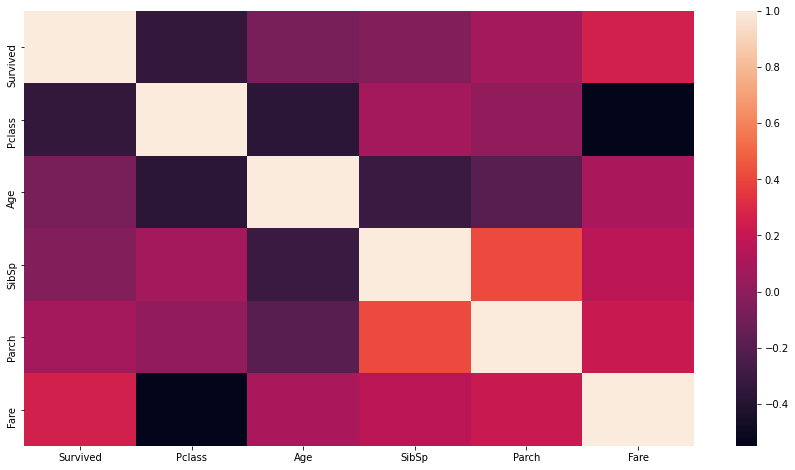

<AxesSubplot:>

In [0]:
# set the size of seaborn plot
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pylab import rcParams

rcParams['figure.figsize'] = 15,8

pd=df1.drop("PassengerID").toPandas()

sb.heatmap(pd.corr())

Out[49]:

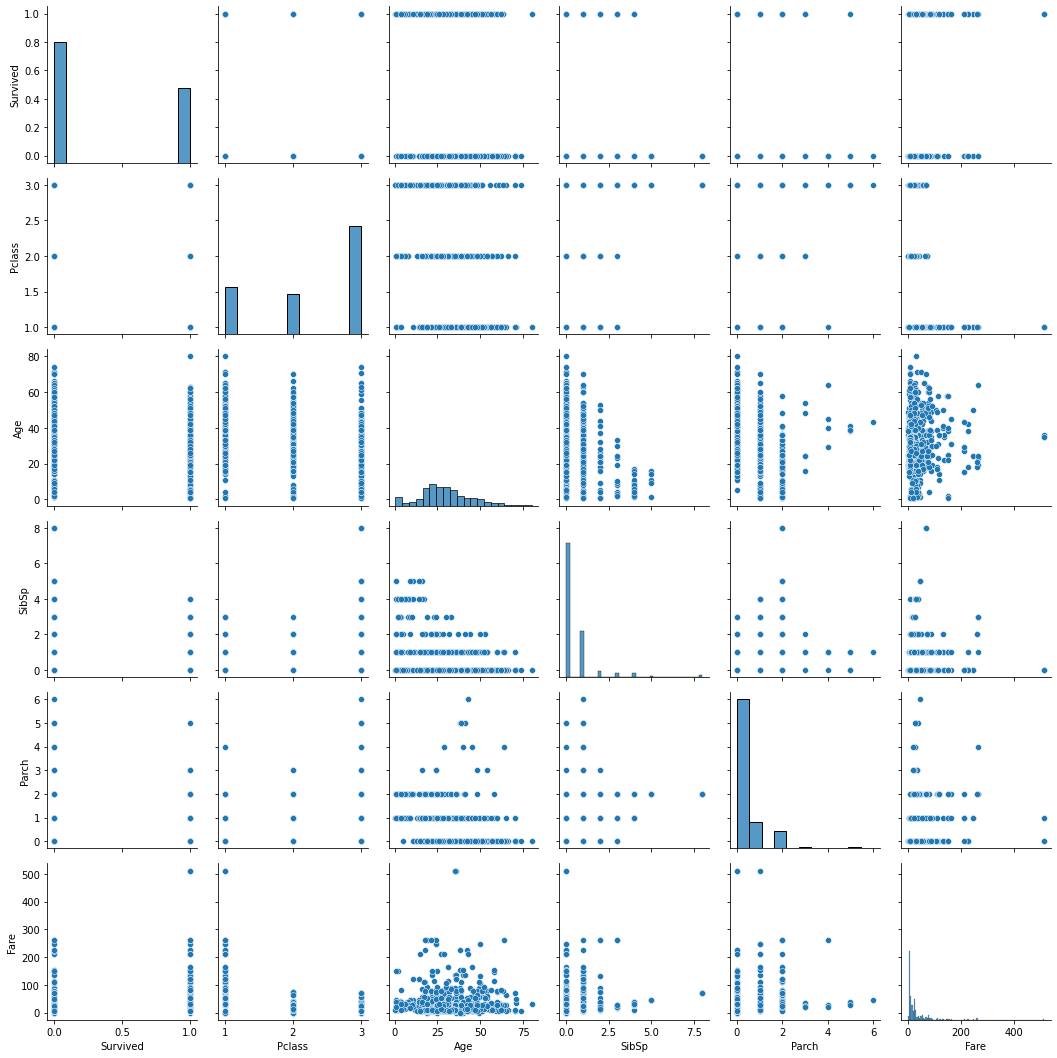

<seaborn.axisgrid.PairGrid at 0x7fb1d00509d0>

In [0]:
pd=df1.drop("PassengerID").toPandas()
g = sb.PairGrid(pd)
g.map_diag(sb.histplot)
g.map_offdiag(sb.scatterplot)

Out[50]:

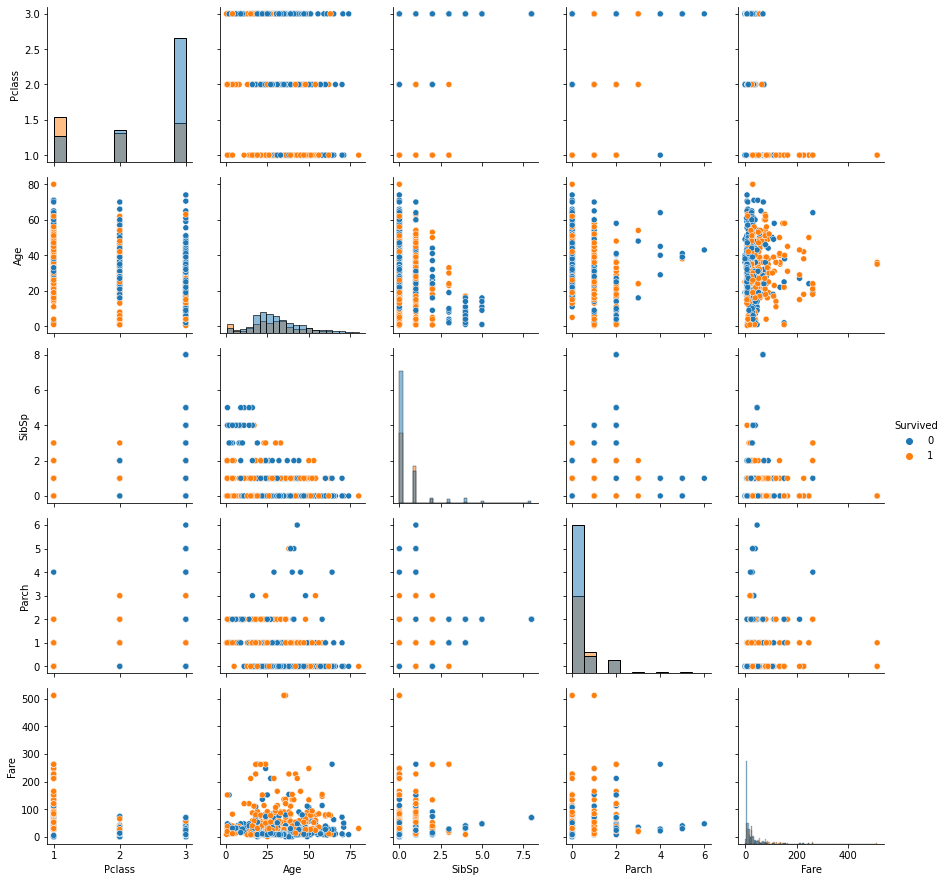

<seaborn.axisgrid.PairGrid at 0x7fb1bc31cb80>

In [0]:
pd=df1.drop("PassengerID").toPandas()
g = sb.PairGrid(pd, hue="Survived")
g.map_diag(sb.histplot)
g.map_offdiag(sb.scatterplot)
g.add_legend()